# Линейная алгебра: сходство текстов и аппроксимация функций

### Вы научитесь:
  * читать тексты из файла с помощью Python и разбивать их на слова
  * переводить тексты в векторные пространства, вычислять расстояния в этих пространствах
  * решать системы линейных уравнений
  * приближать любые функции с помощью многочленов
  
## Введение

В этом задании вы познакомитесь с некоторыми базовыми методами из линейной алгебры, реализованными в пакете SciPy — в частности, с методами подсчета косинусного расстояния и решения систем линейных уравнений. Так, на решении систем линейных уравнений основана настройка линейных моделей — очень большого и важного класса алгоритмов машинного обучения. Косинусное расстояние же часто используется в анализе текстов для измерения сходства между ними.

## Материалы

Справка по функциям пакета scipy.linalg: http://docs.scipy.org/doc/scipy/reference/linalg.html

Справка по работе с файлами в Python: https://docs.python.org/2/tutorial/inputoutput.html#reading-and-writing-files

Справка по регулярным выражениям в Python (если вы захотите узнать про них чуть больше): https://docs.python.org/2/library/re.html

## Задача 1: сравнение предложений

Дан набор предложений, скопированных с Википедии. Каждое из них имеет "кошачью тему" в одном из трех смыслов:

  * кошки (животные)
  * UNIX-утилита cat для вывода содержимого файлов
  * версии операционной системы OS X, названные в честь семейства кошачьих
Ваша задача — найти два предложения, которые ближе всего по смыслу к расположенному в самой первой строке. В качестве меры близости по смыслу мы будем использовать косинусное расстояние.

#### Выполните следующие шаги:

1. Скачайте файл с предложениями (sentences.txt).
2. Каждая строка в файле соответствует одному предложению. Считайте их, приведите каждую к нижнему регистру с помощью строковой функции lower().
3. Произведите токенизацию, то есть разбиение текстов на слова. Для этого можно воспользоваться регулярным выражением, которое считает разделителем любой символ, не являющийся буквой: re.split('[^a-z]', t). Не забудьте удалить пустые слова после разделения.
4. Составьте список всех слов, встречающихся в предложениях. Сопоставьте каждому слову индекс от нуля до (d - 1), где d — число различных слов в предложениях. Для этого удобно воспользоваться структурой dict.
5. Создайте матрицу размера n x d, где n — число предложений. Заполните ее: элемент с индексом (i, j) в этой матрице должен быть равен количеству вхождений j-го слова в i-е предложение. У вас должна получиться матрица размера 22 * 254.
6. Найдите косинусное расстояние от предложения в самой первой строке (In comparison to dogs, cats have not undergone...) до всех остальных с помощью функции scipy.spatial.distance.cosine. Какие номера у двух предложений, ближайших к нему по этому расстоянию (строки нумеруются с нуля)? Эти два числа и будут ответами на задание.
7. Совпадают ли ближайшие два предложения по тематике с первым? Совпадают ли тематики у следующих по близости предложений?

Разумеется, использованный вами метод крайне простой. Например, он не учитывает формы слов (так, cat и cats он считает разными словами, хотя по сути они означают одно и то же), не удаляет из текстов артикли и прочие ненужные слова.

In [132]:
import re

import numpy as np
import pandas as pd
from scipy import spatial

anchor_line: int = 0

df: pd.DataFrame = pd.DataFrame(
    [x for x in re.split("[^a-z]", line.lower()) if x not in ["", " ", None, "None"]]
    for line in open("sentences.txt", "r").readlines()
)

unique_values: np.array = np.sort(
    np.array([x for x in pd.unique(df.values.ravel()) if x is not None])
)

occurrence_matrix: np.array = np.zeros(
    (df.values.shape[0], unique_values.size), dtype=int
)

for i, sentence in enumerate(df.values):
    for word in sentence:
        if word in unique_values:
            j = np.where(unique_values == word)[0][0]
            occurrence_matrix[i][j] += 1

distances: dict[int : list[dict]] = {anchor_line: []}

for i in range(occurrence_matrix.shape[0]):
    if anchor_line == i:
        continue

    distances[anchor_line].append(
        {
            "index": i,
            "distance": spatial.distance.cosine(
                occurrence_matrix[anchor_line],
                occurrence_matrix[i],
            ),
            "sentence": " ".join([word for word in df.values[i] if word != None]),
        }
    )

distances[anchor_line] = sorted(
    distances[anchor_line],
    key=lambda x: x["distance"],
    reverse=True,
)

print([x["index"] for x in distances[anchor_line][:2]])

[17, 1]


## Задача 2: аппроксимация функции

Рассмотрим сложную математическую функцию на отрезке [1, 15]:

f(x) = sin(x / 5) * exp(x / 10) + 5 * exp(-x / 2)

Она может описывать, например, зависимость оценок, которые выставляют определенному сорту вина эксперты, в зависимости от возраста этого вина. По сути, задача машинного обучения состоит в том, чтобы приблизить сложную зависимость с помощью функции из определенного семейства. В этом задании мы будем приближать указанную функцию с помощью многочленов.

Как известно, многочлен степени n (то есть w_0 + w_1 x + w_2 x^2 + ... + w_n x^n) однозначно определяется любыми n + 1 различными точками, через которые он проходит. Это значит, что его коэффициенты w_0, ... w_n можно определить из следующей системы линейных уравнений:


где через x_1, ..., x_n, x_{n+1} обозначены точки, через которые проходит многочлен, а через f(x_1), ..., f(x_n), f(x_{n+1}) — значения, которые он должен принимать в этих точках.

Воспользуемся описанным свойством, и будем находить приближение функции многочленом, решая систему линейных уравнений.

1. Сформируйте систему линейных уравнений (то есть задайте матрицу коэффициентов A и свободный вектор b) для многочлена первой степени, который должен совпадать с функцией f в точках 1 и 15. Решите данную систему с помощью функции scipy.linalg.solve. Нарисуйте функцию f и полученный многочлен. Хорошо ли он приближает исходную функцию?
2. Повторите те же шаги для многочлена второй степени, который совпадает с функцией f в точках 1, 8 и 15. Улучшилось ли качество аппроксимации?
3. Повторите те же шаги для многочлена третьей степени, который совпадает с функцией f в точках 1, 4, 10 и 15. Хорошо ли он аппроксимирует функцию?

In [4]:
import math
from matplotlib import pyplot as plt
import numpy as np
from scipy.linalg import solve

anchor_point_1: list[float] = [1, 15]
anchor_point_2: list[float] = [1, 8, 15]
anchor_point_3: list[float] = [1, 4, 10, 15]

first degree poly: [np.float64(3.43914511139233), np.float64(-0.18692824612091097)]
second degree poly: [np.float64(3.3251294940571725), np.float64(-0.06531158763007618), np.float64(-0.0076010411556771745)]
third degree poly: [np.float64(4.362641535118072), np.float64(-1.2955258656948436), np.float64(0.1933368470215116), np.float64(-0.008235651173320552)]


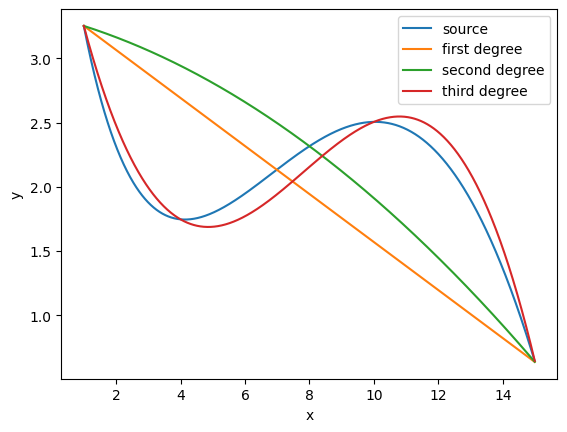

In [22]:
def f(x):
    return math.sin(x / 5.0) * math.exp(x / 10.0) + 5 * math.exp(-x / 2.0)


def value_polynomial(w_s: list[float], x: float) -> list:
    value = 0

    for i in range(len(w_s)):
        value += w_s[i] * x**i

    return value


def solve_polynomial(anchor_point: list[float]) -> list:
    a = np.array(
        [
            [anchor_point[j] ** i for i in range(len(anchor_point))]
            for j in range(len(anchor_point))
        ]
    )

    b = np.array([f(x) for x in anchor_point])

    x = solve(a, b)

    return list(x)


w_1 = solve_polynomial(anchor_point_1)
w_2 = solve_polynomial(anchor_point_2)
w_3 = solve_polynomial(anchor_point_3)

print(f"first degree poly: {w_1}")
print(f"second degree poly: {w_2}")
print(f"third degree poly: {w_3}")

x = np.arange(1, 15, 0.01)

y_source = list(map(f, x))
y_1 = list(map(lambda x: value_polynomial(w_1, x), x))
y_2 = list(map(lambda x: value_polynomial(w_2, x), x))
y_3 = list(map(lambda x: value_polynomial(w_3, x), x))

plt.plot(x, y_source, label="source")
plt.plot(x, y_1, label="first degree")
plt.plot(x, y_2, label="second degree")
plt.plot(x, y_3, label="third degree")

plt.xlabel("x")
plt.ylabel("y")

plt.legend()